# Check tracer mass on shelf and in HCW (calculation) 

Check why tracer in HCW is so big compared to the total tracer mass on shelf (almost 1/9th)

In [4]:
# Calculate and save HCW and tracer mass on shelf
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [5]:
# -------------------------------------------------------------------------------------------------------------------------
def Tracer_AlongShelf(Tr,TrAdv,MaskC,rA,hFacC,drF,yin,zfin,xi,yi,nzlim):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, size 19x90x360x360
    TrAdv : Array with concentration values for low diffusivity tracer. Until this function is more general, size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TrMass =  Array with the mass of tracer over the shelf in HCW [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,TrAdv)

    TrMask=np.ma.array(TrAdv,mask=maskExp)   
    Tr1Mask=np.ma.array(Tr,mask=maskExp)   
    
    trlim1 = TrMask[0,nzlim,yi,xi]
    trlim2 = TrMask[0,nzlim+1,yi,xi]
    trlim = (trlim1+trlim2)/2
    print('tracer limit concentration is: ',trlim)
    print(trlim1,trlim2)


    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask

    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)

    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
   
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    TrConc_HCW = np.ma.masked_array(Tr[:,:zfin,yin:,:],mask = HighConc_Mask) 

    MassTrHighConc =np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol*TrConc_HCW,axis = 1),axis=1),axis=1)

    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:],axis = 1),axis=1),axis=1)
    
    print('The volume of the shelf is')
    print(np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp,axis = 1),axis=1),axis=1))
    print('The volume of HCW is') 
    print(np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1))
    
    return (MassTrHighConc, Total_Tracer, TrConc_HCW, ShelfVolume_exp, Tr1Mask, TrMask,HighConc_CellVol)

In [6]:
# Load grid files
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [7]:
# Load records for each run
import os
import sys
lib_path = os.path.abspath('Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [8]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [9]:
records_sel = [records[0]]
recordsNoC_sel = [recordsNoC[0]]



In [10]:
# Calculate HCW and TR Mass
for record in records_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
     
    TrMassHCW, TotTrMass,TrConc_HCW, ShelfVolume_exp, Tr1Mask, TrMask, HC_vol = Tracer_AlongShelf(Tr1,Tr2, 
                                                                                          MaskCNoC, 
                                                                                          rA, 
                                                                                          hFacCNoC, 
                                                                                          drF[:], 
                                                                                          227, 30,  180, 50,29)
    
     
for record in recordsNoC_sel:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
     
    TrMassHCWNoC, TotTrMassNoC,TrConc_HCWNoC, ShelfVolume_expNoC, Tr1MaskNoC, TrMaskNoC, HC_volNoC = Tracer_AlongShelf(Tr1,Tr2, 
                                                                                                            MaskCNoC, 
                                                                                                            rA, 
                                                                                                            hFacCNoC, 
                                                                                                            drF[:], 
                                                                                                            227, 30,  
                                                                                                            180, 50,
                                                                                                            29)
  

tracer limit concentration is:  7.30753135681
7.21757 7.39749
The volume of the shelf is
[  2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.53568478e+11   2.53568478e+11   2.53568478e+11]
The volume of HCW is
[-- -- 11135154.842939835 284320783.2557537 1697270270.7066464
 3549842355.1817966 5017714456.921667 6561677957.717172 8465403198.606054
 10112467405.213232 11961531072.511818 13794218984.883823
 15266338728.271454 16503039465.048292 17377920952.3636 17871614462.65523
 18627931599.64813 19430335287.271233 20326761694.0894]
tracer limit concentration is:  7.30753135681
7.21757 7.39749
The volume of the shelf is
[  2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.53568478e+11   2.53568478e+11   2.53568478e+11   2.53568478e+11
   2.5356

Good, the volumes make sense. Shelf volume does not change in time and is $O(10^{11})$ m$^3$ while volume of HCW is $O(10^7-10^9)$ m$^3$.  Also, note that HCW volume is zero at t=0 when I chose z[30] instead of z[29] as the nzlim. 

### Comparison of shelf concnetrations and HCW concentrations

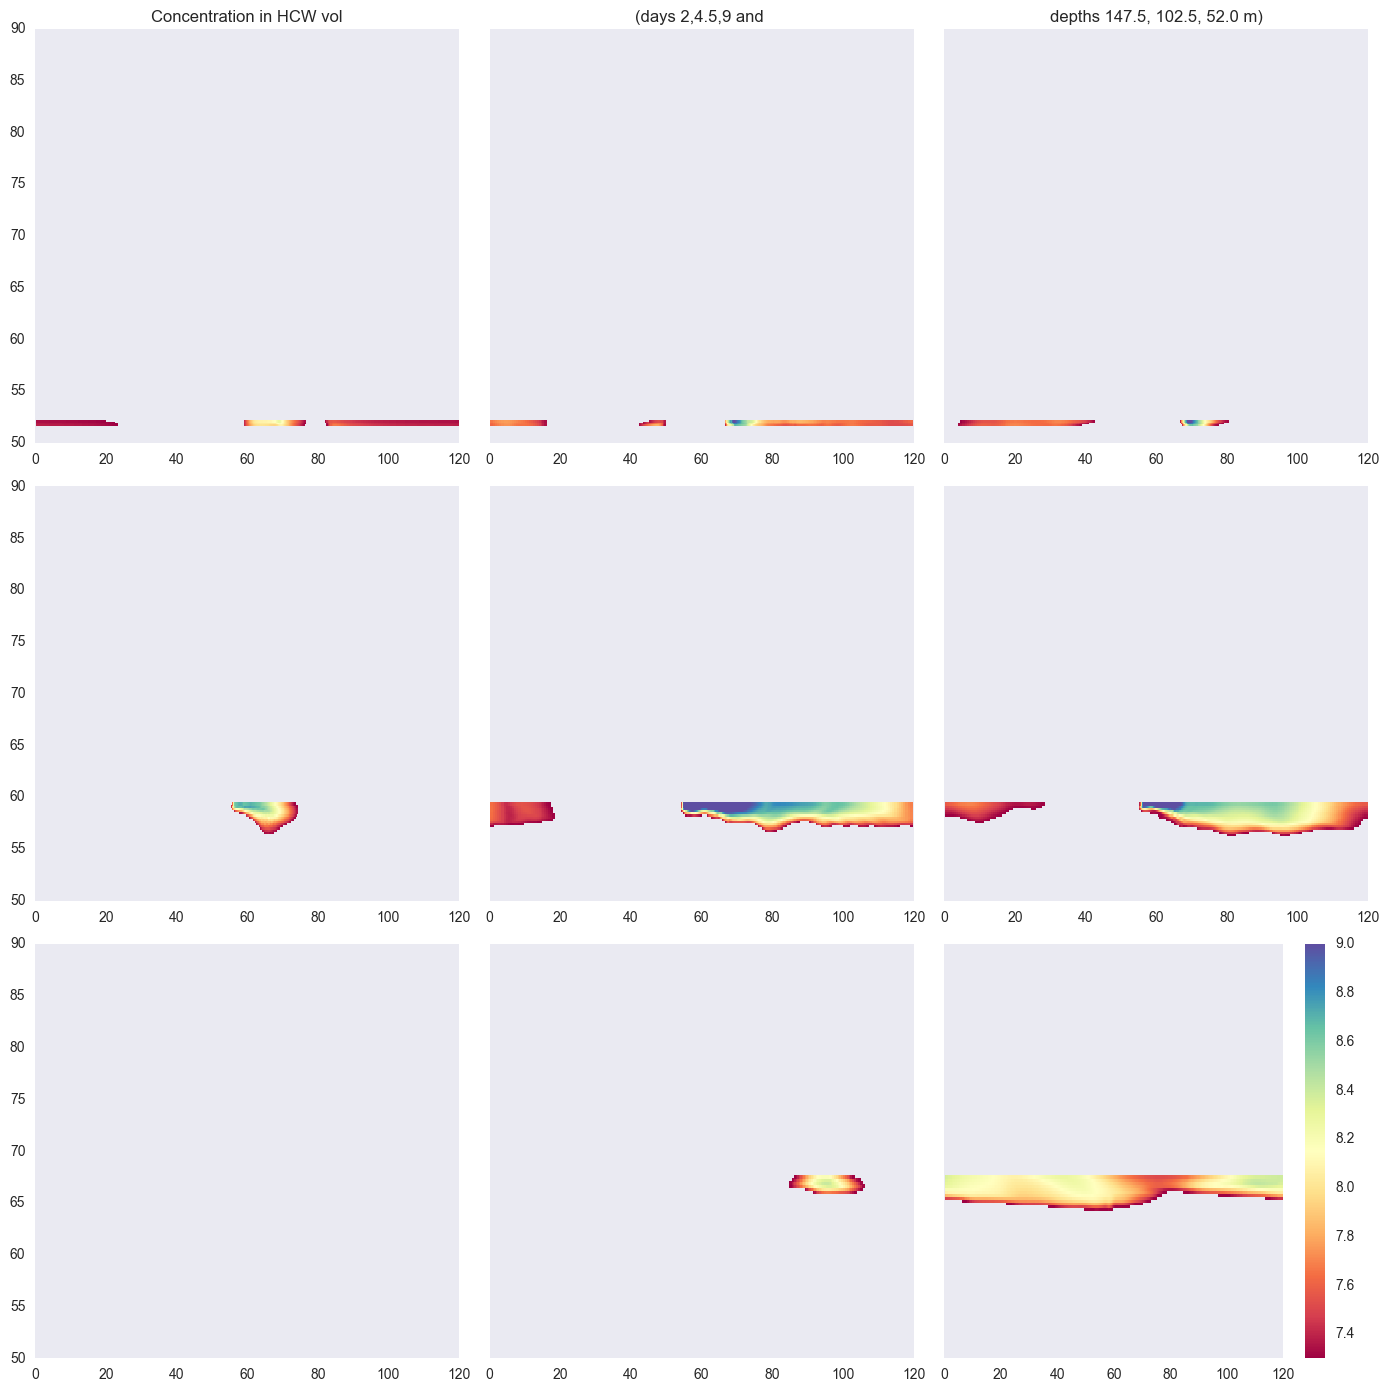

In [11]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[4,29,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[9,29,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[18,29,:,:],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[4,20,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[9,20,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[18,20,:,:],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[4,10,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[9,10,:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,TrConc_HCW[18,10,:,:],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration in HCW vol')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

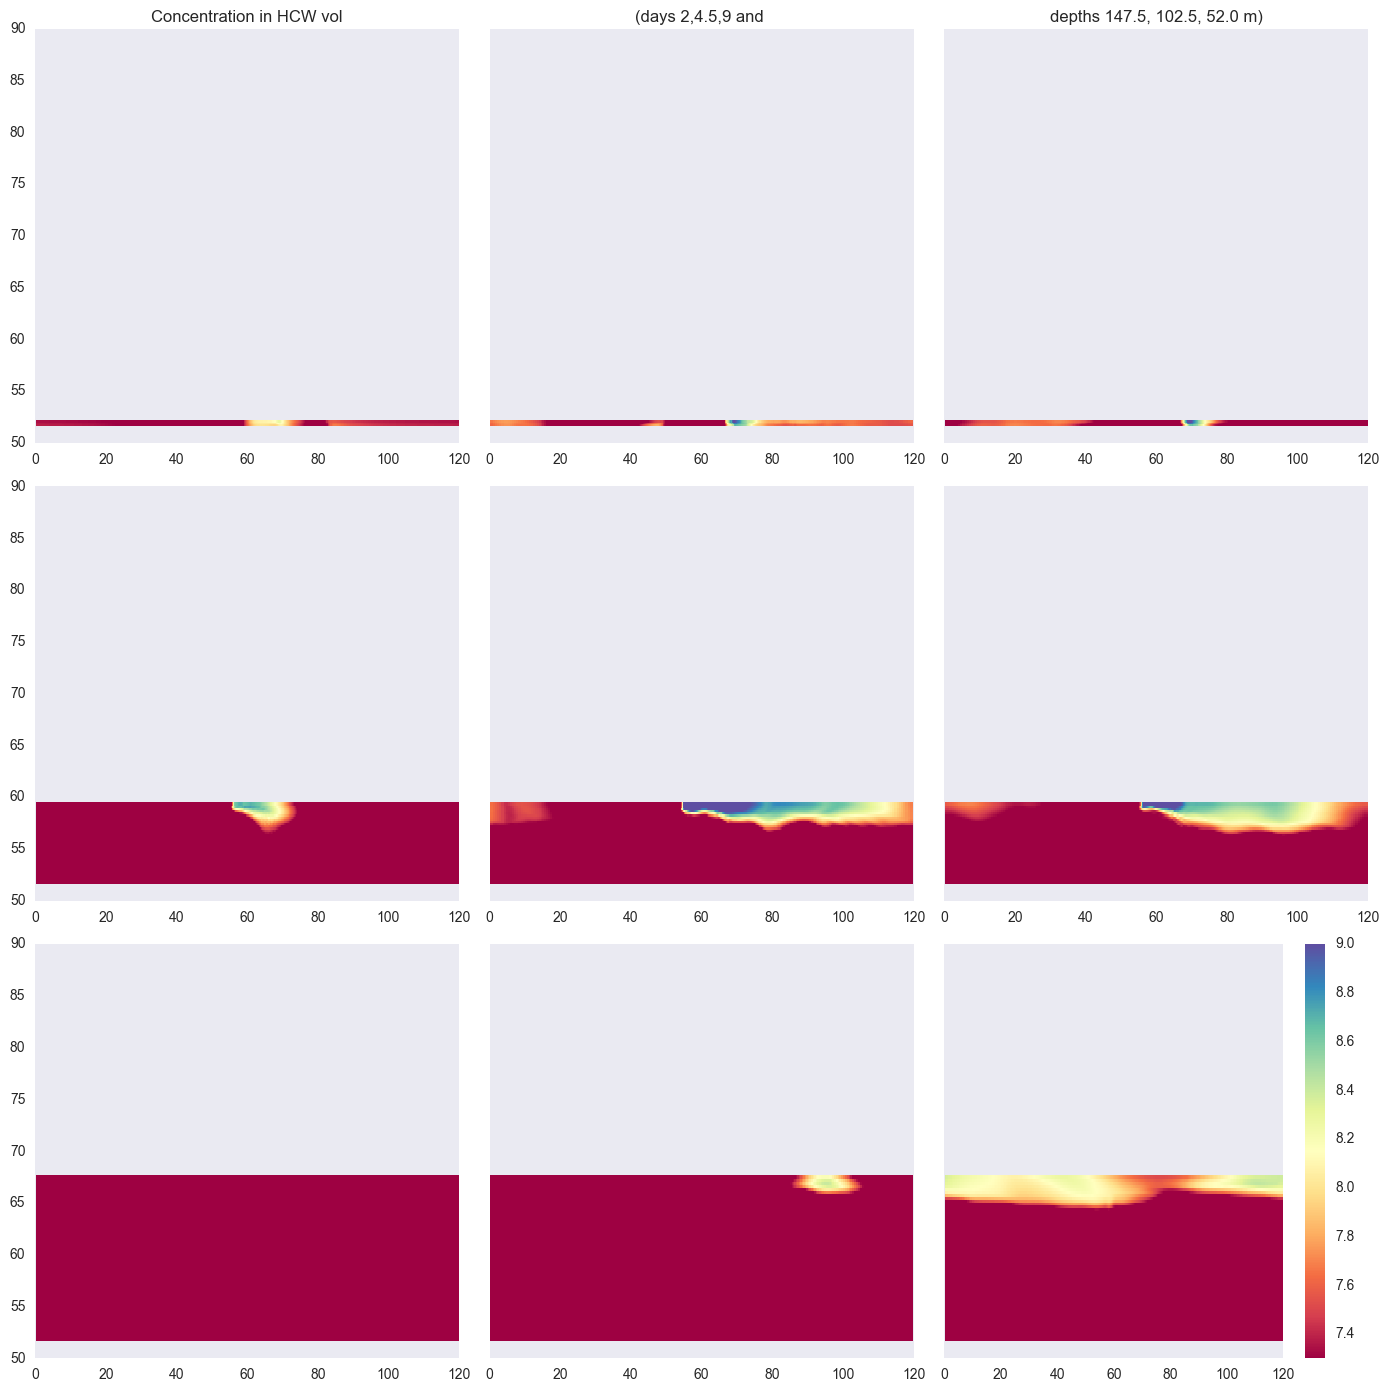

In [12]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[4,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[9,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[18,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[4,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[9,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[18,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[4,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[9,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1Mask[18,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration in HCW vol')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

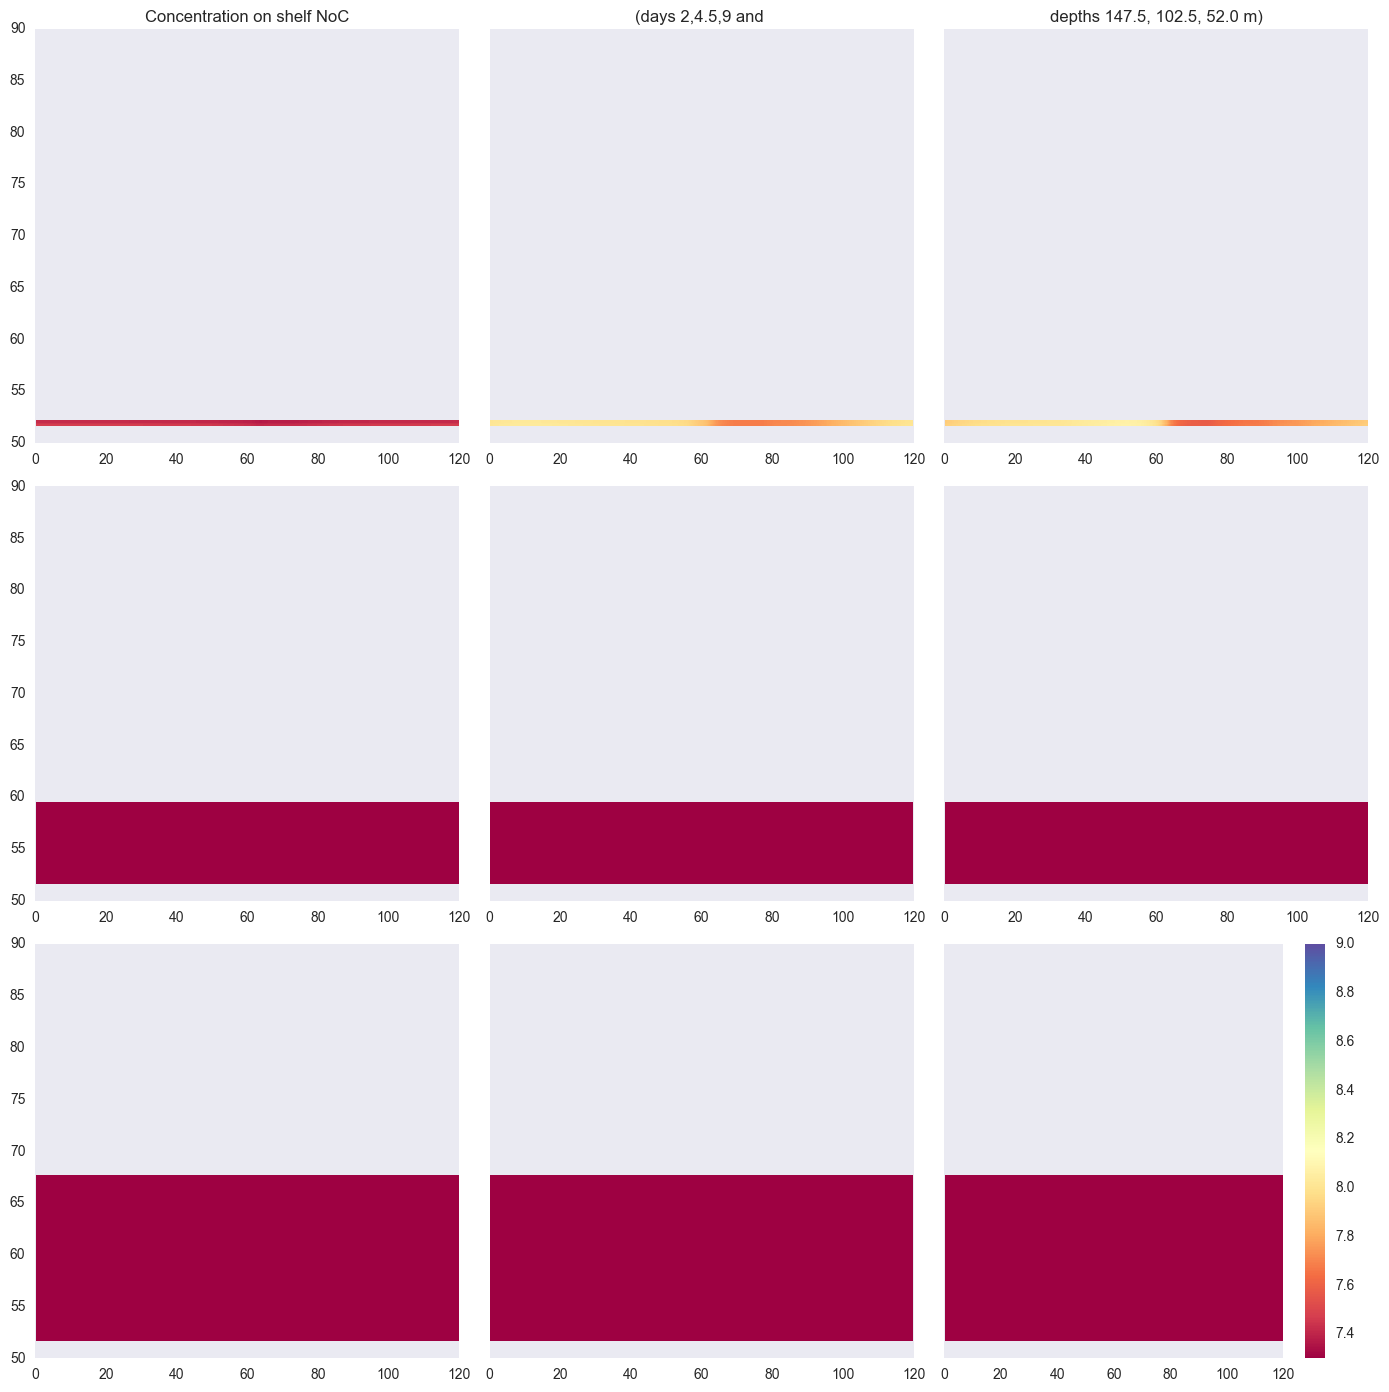

In [13]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[4,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[9,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[18,29,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[4,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[9,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[18,20,227:,:],vmax=9,vmin=7.3, cmap='Spectral',)

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[4,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[9,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,Tr1MaskNoC[18,10,227:,:],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration on shelf NoC')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

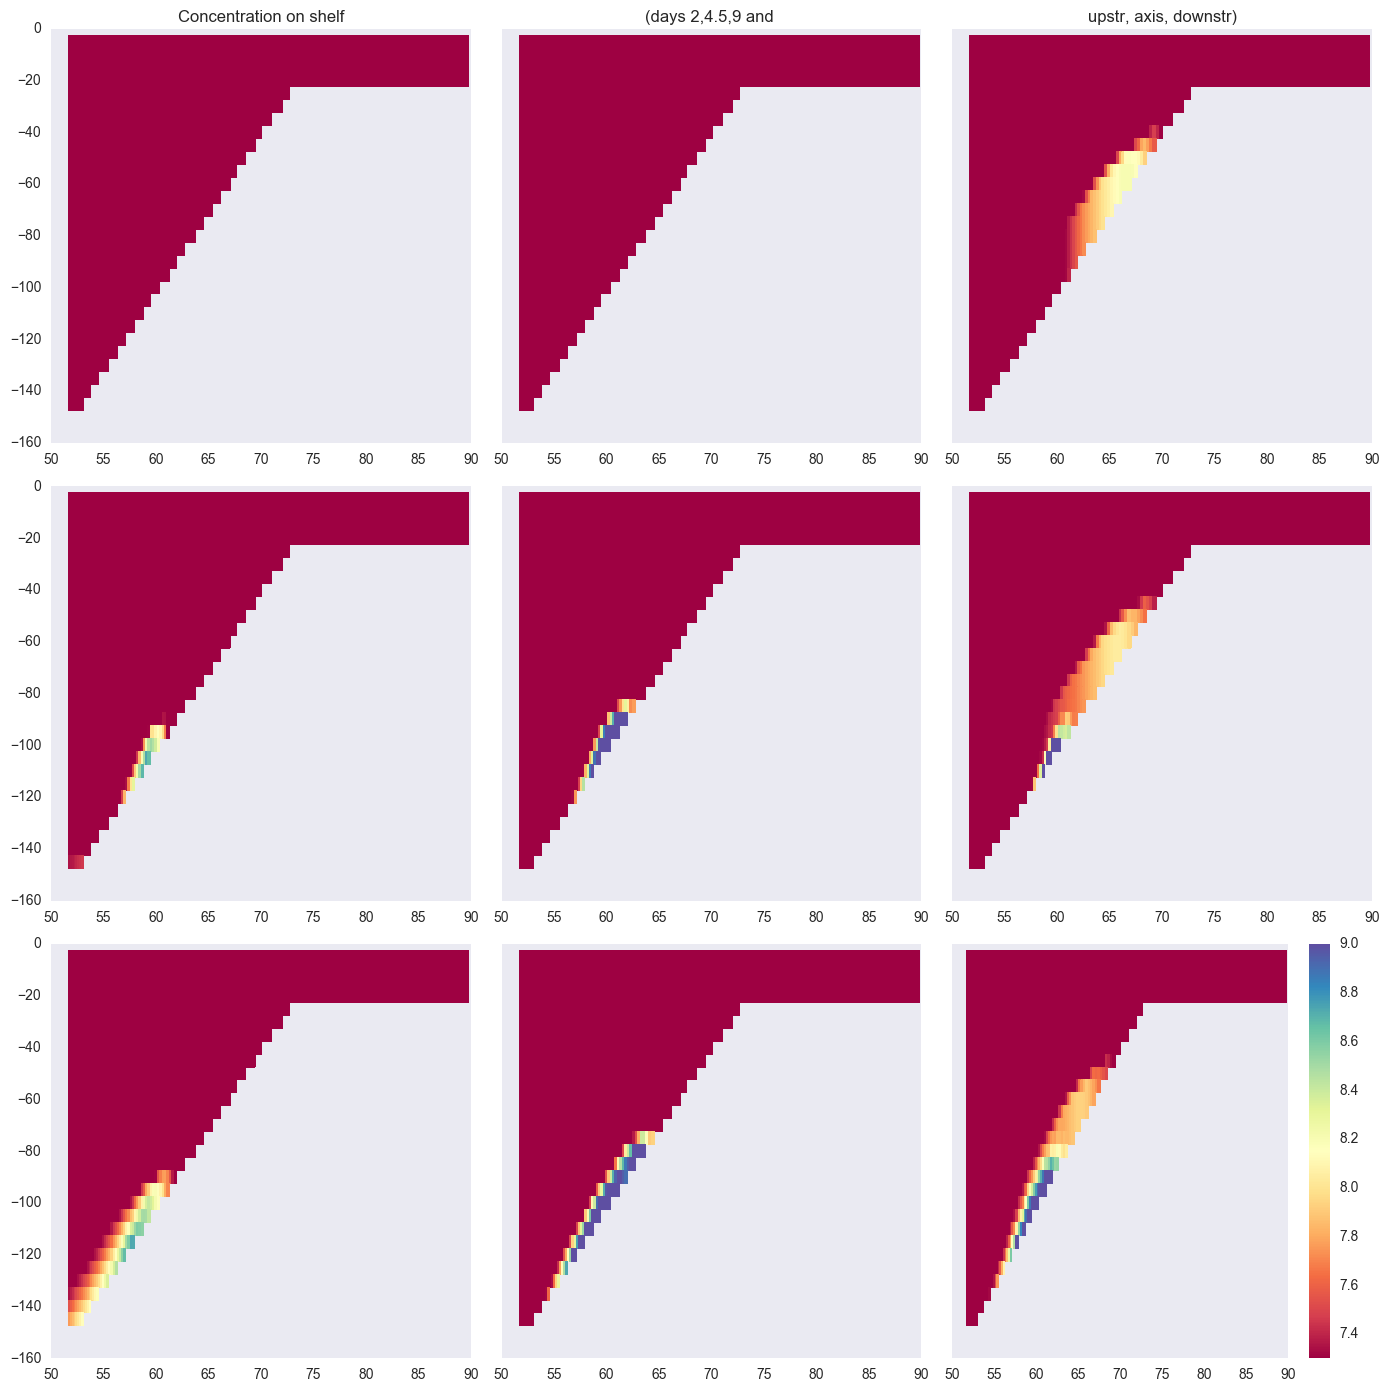

In [14]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[4,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[9,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[18,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[4,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[9,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[18,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[4,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[9,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1Mask[18,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration on shelf')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('upstr, axis, downstr)')

plt.tight_layout()

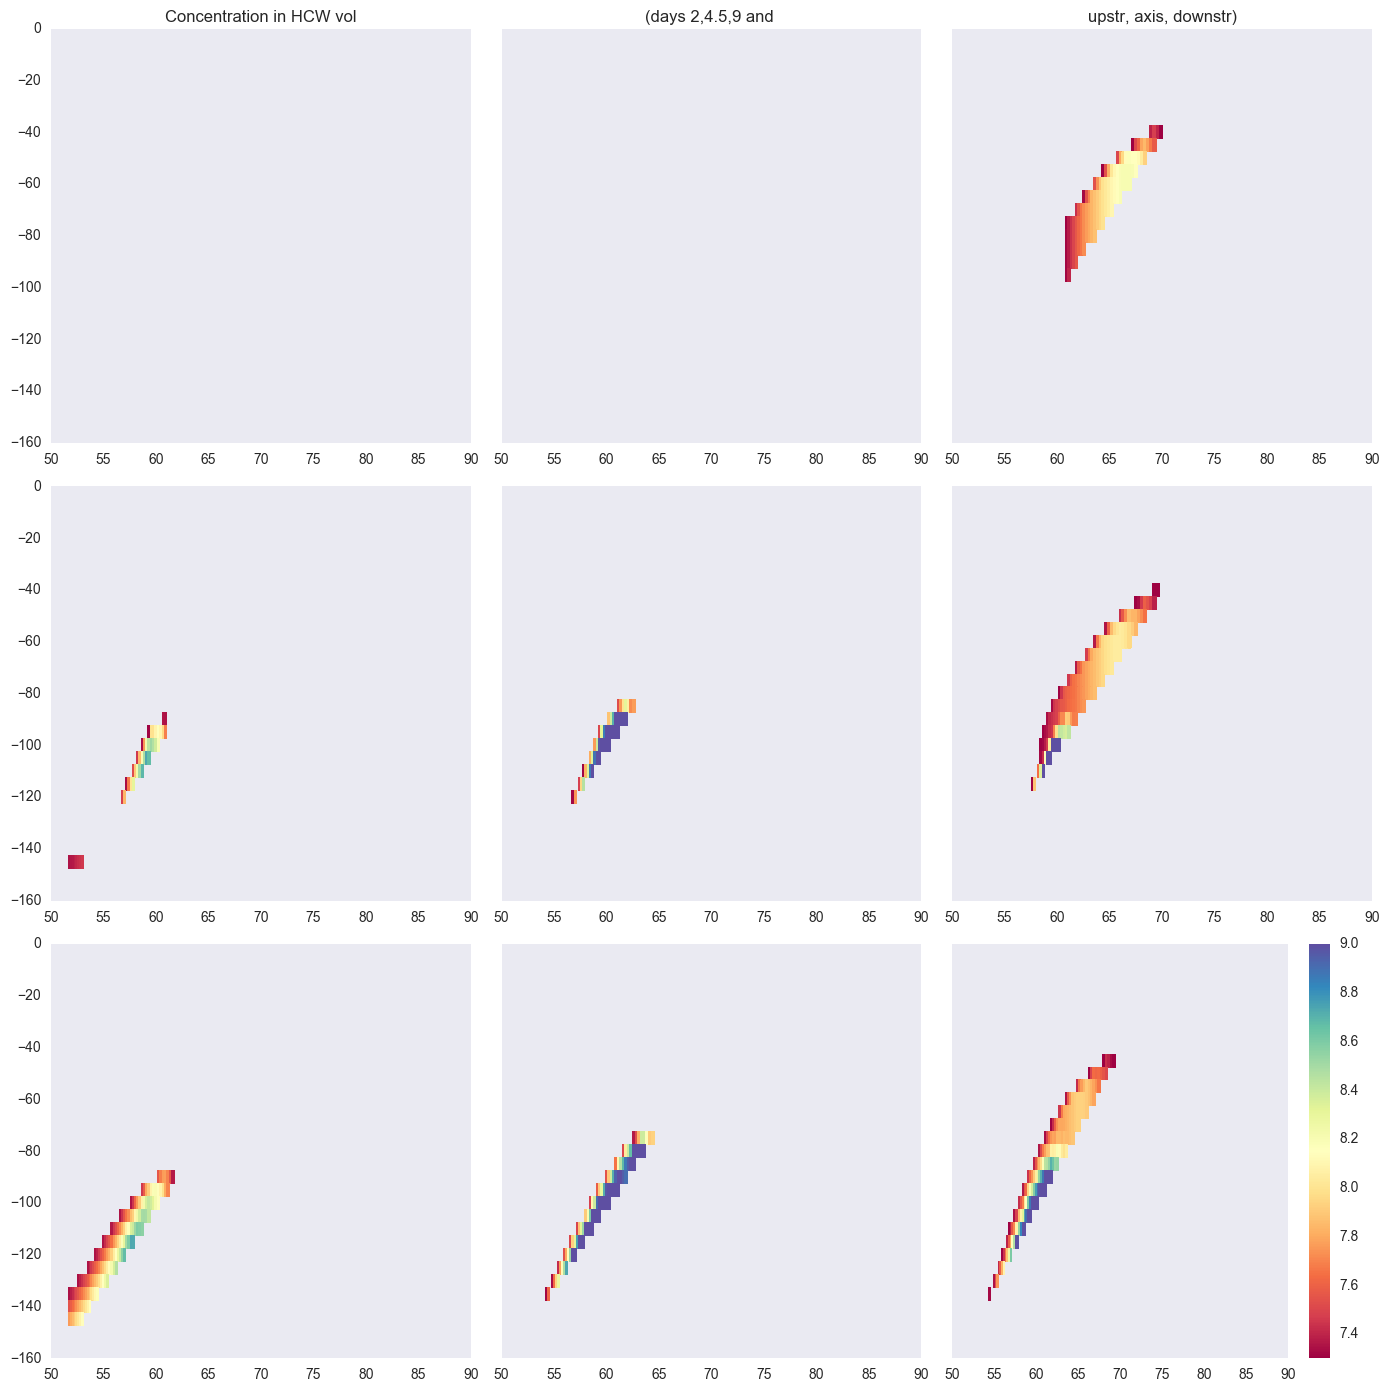

In [15]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[4,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[9,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[18,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[4,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[9,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[18,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[4,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[9,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCW[18,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration in HCW vol')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('upstr, axis, downstr)')

plt.tight_layout()

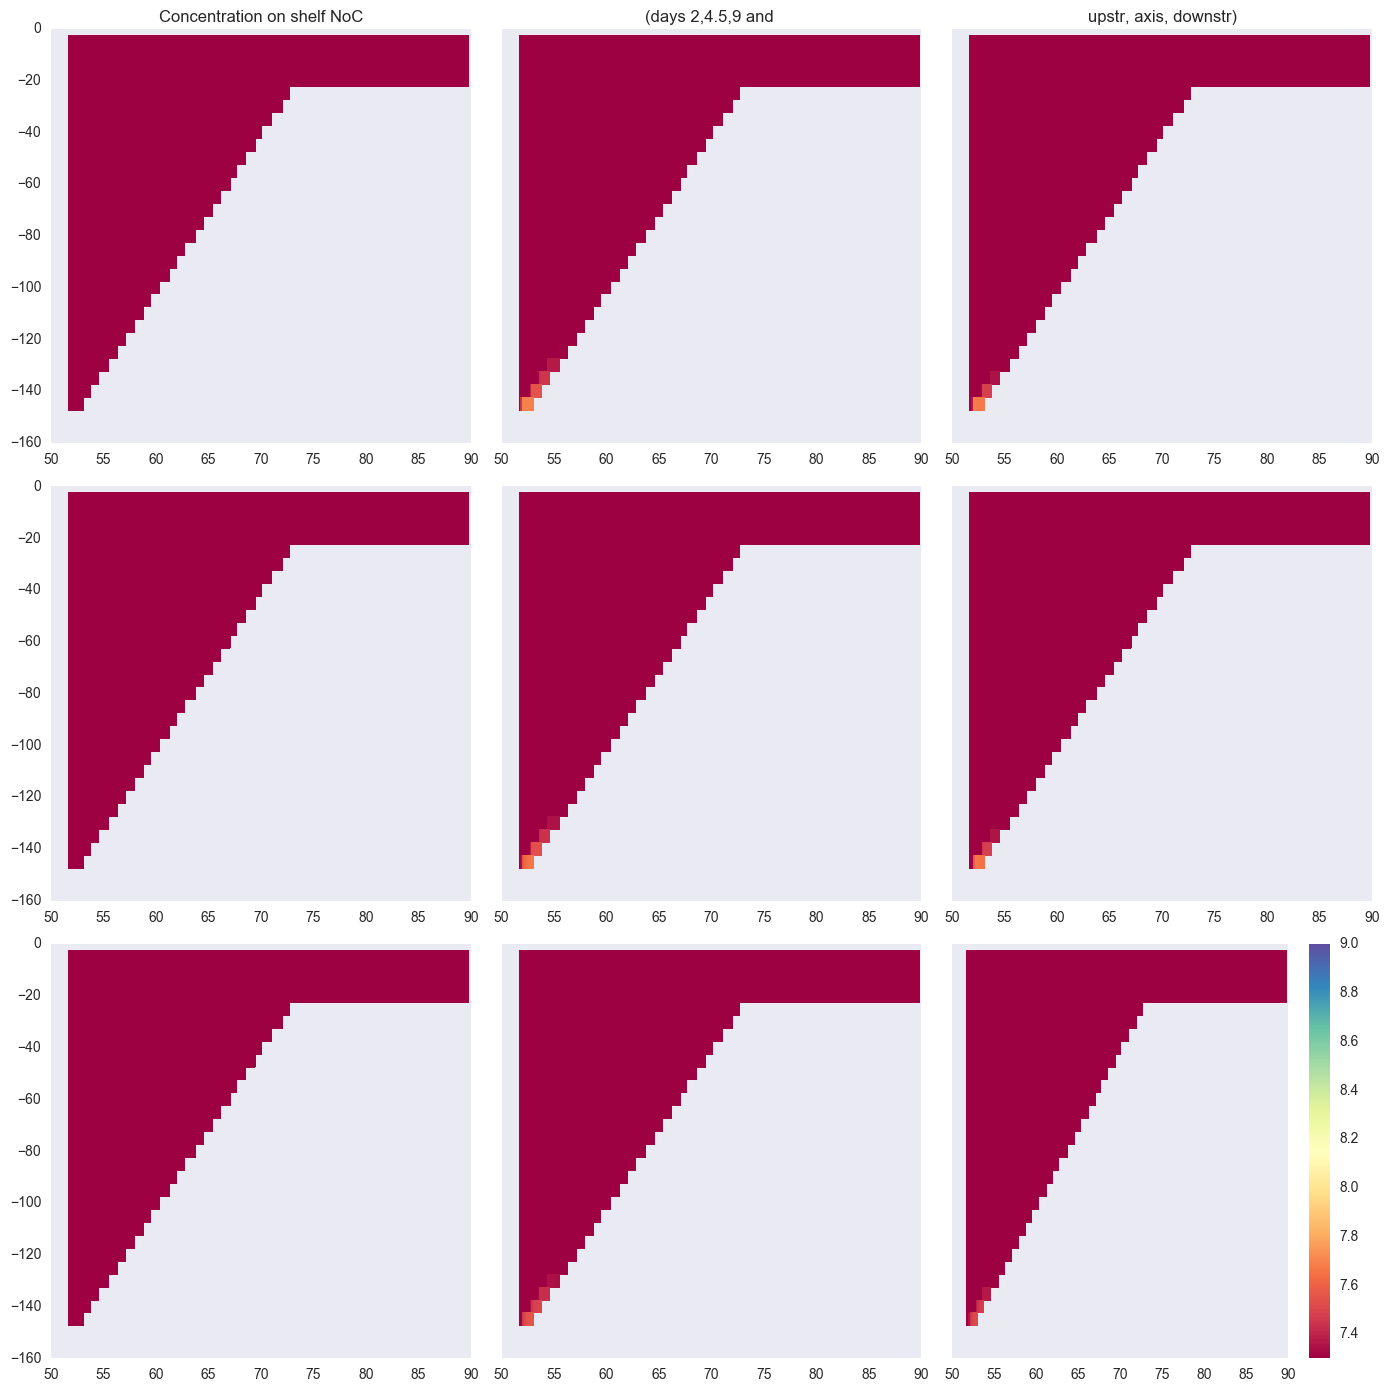

In [16]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[4,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[9,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[18,:30,227:,120],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[4,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[9,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[18,:30,227:,180],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[4,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[9,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(yc[227:,1]/1000,rc[:30],Tr1MaskNoC[18,:30,227:,220],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration on shelf NoC')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('upstr, axis, downstr)')

plt.tight_layout()

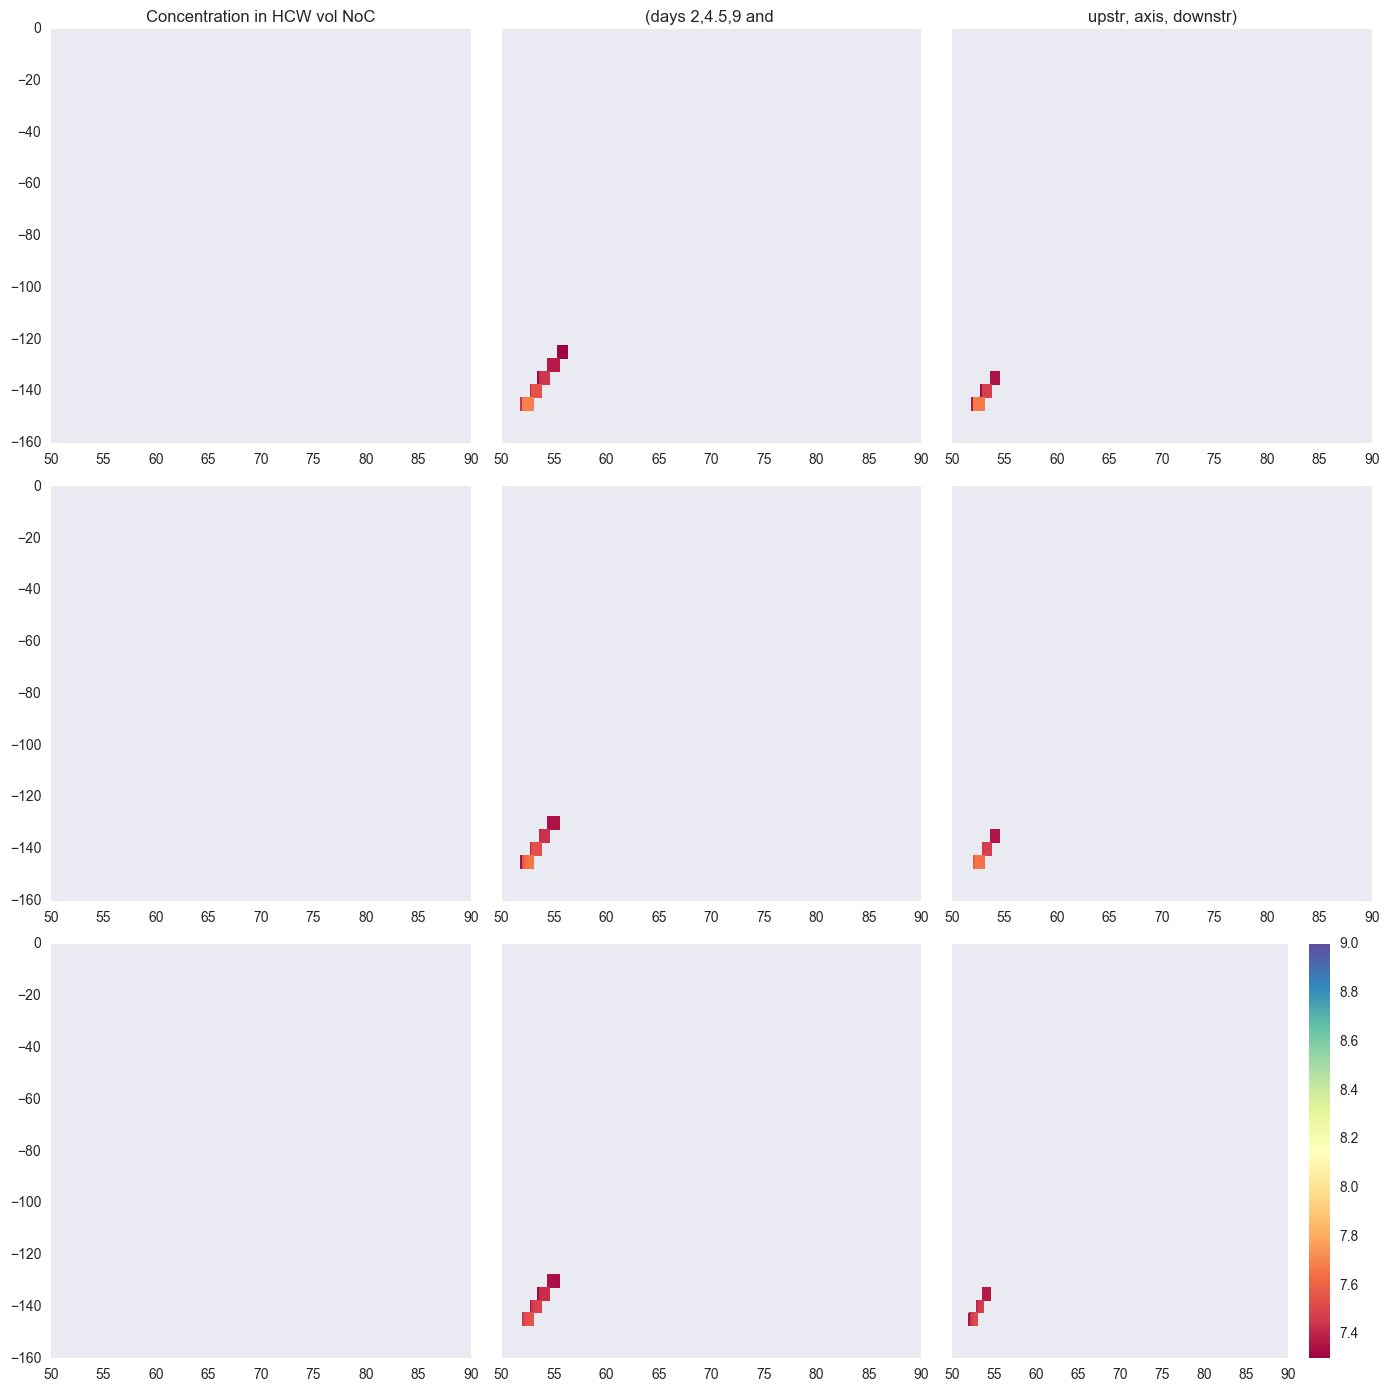

In [17]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[4,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[0,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[9,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[0,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[18,:,:,120],vmax=9,vmin=7.3, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[4,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[1,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[9,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[1,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[18,:,:,180],vmax=9,vmin=7.3, cmap='Spectral')

pc0 = ax[2,0].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[4,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc1 = ax[2,1].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[9,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')
pc2 = ax[2,2].pcolor(yc[227:,1]/1000,rc[:30],TrConc_HCWNoC[18,:,:,220],vmax=9,vmin=7.3, cmap='Spectral')

ax[0,0].set_title('Concentration in HCW vol NoC')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('upstr, axis, downstr)')

plt.tight_layout()

The masks work for choosing HCW tracer concentrations and tracer mass on shelf... There's really nothing on shelf in the no canyon case compared to the canyon case (in terms of HCW) but how can it be that TrMass-TrMassNoC is smaller than Tr in HCW for the canyon case? I would assume that it is on that order.

### Comparison of shelf-cell volumes and HCW cell volumes

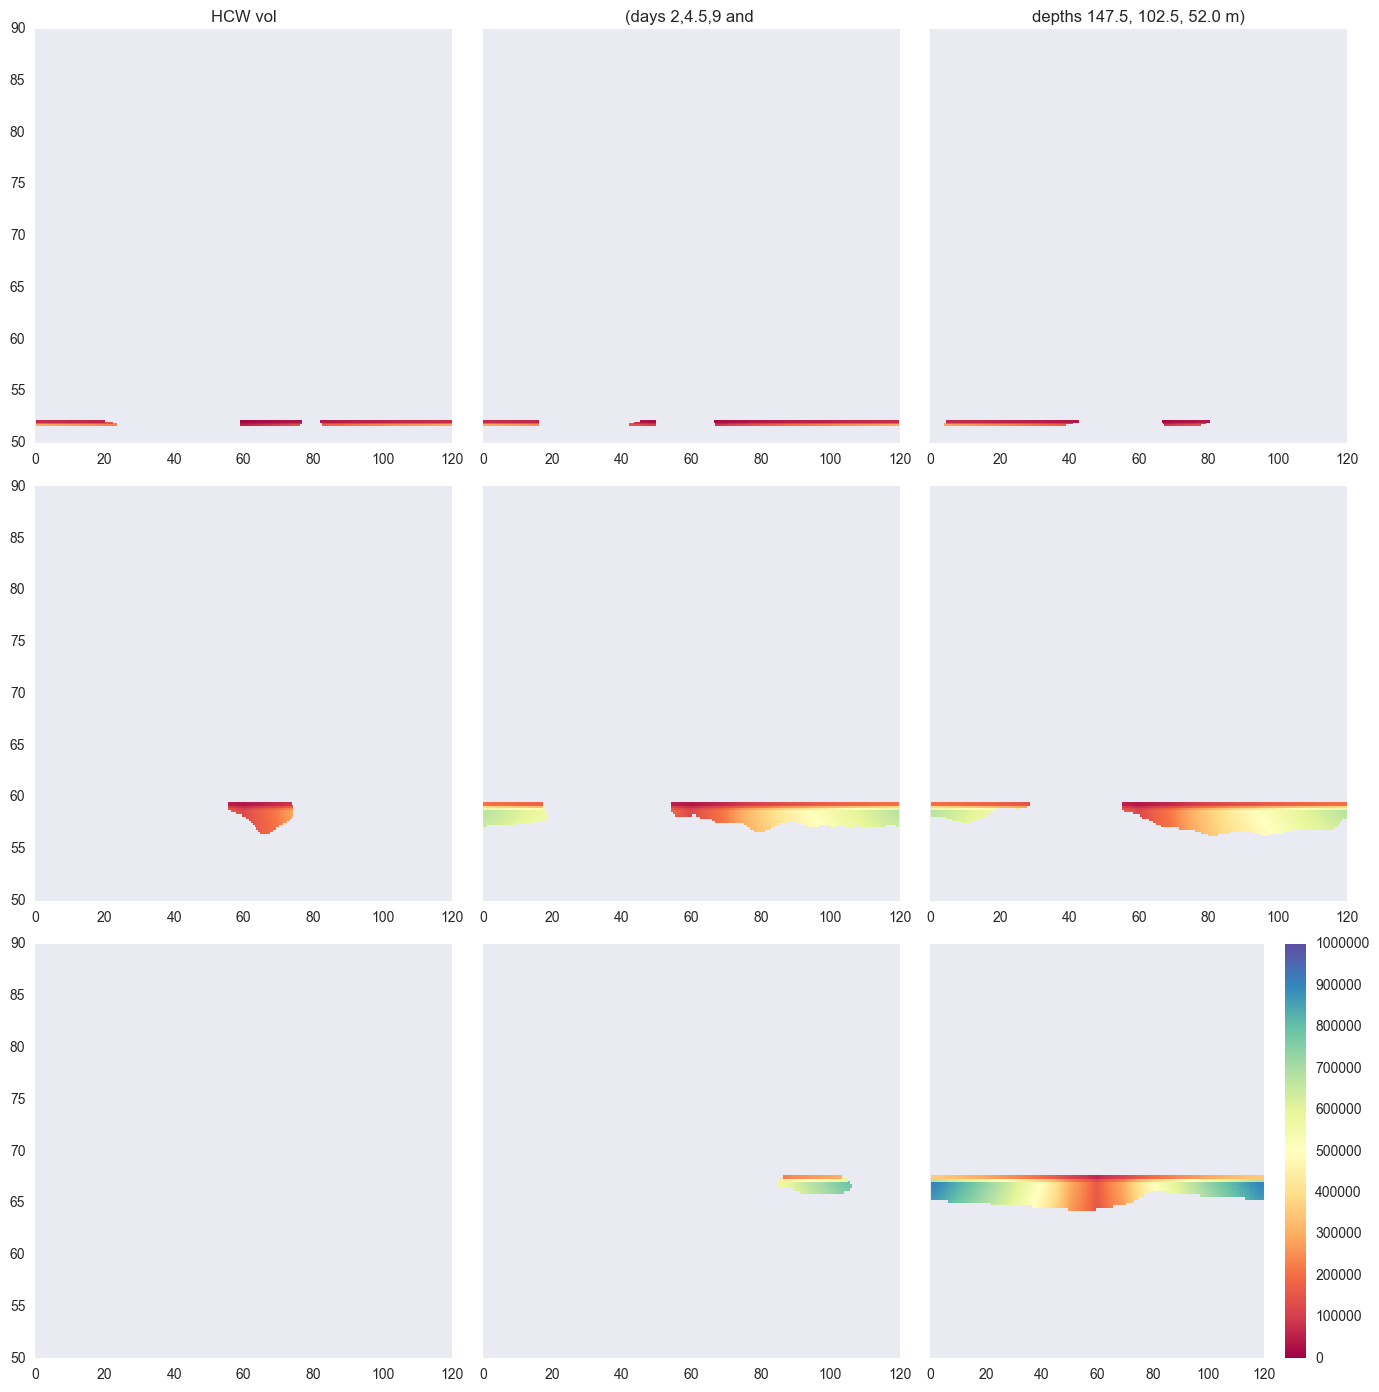

In [18]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[4,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[9,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[18,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[4,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[9,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[18,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[4,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[9,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_vol[18,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')

ax[0,0].set_title('HCW vol')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

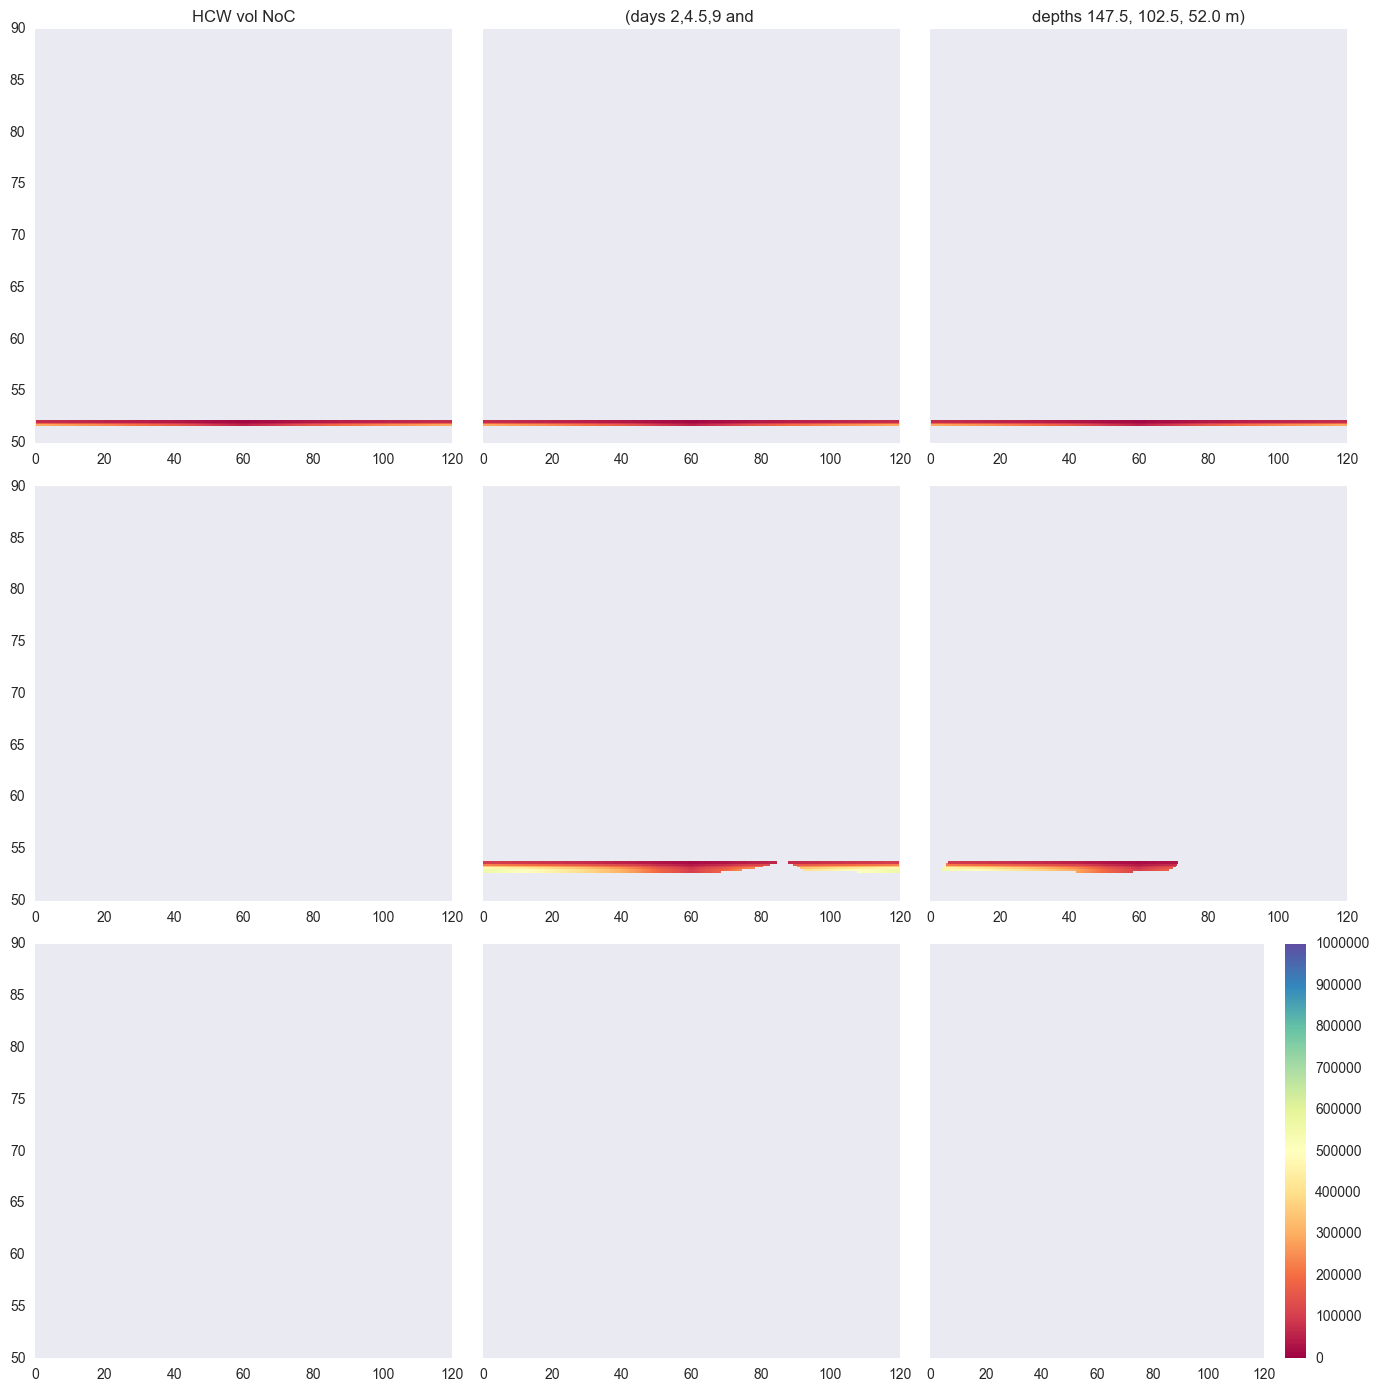

In [19]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[4,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[9,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[18,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[4,27,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[9,27,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[18,27,:,:],vmax=1E6,vmin=0, cmap='Spectral')

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[4,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[9,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,HC_volNoC[18,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')

ax[0,0].set_title('HCW vol NoC')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

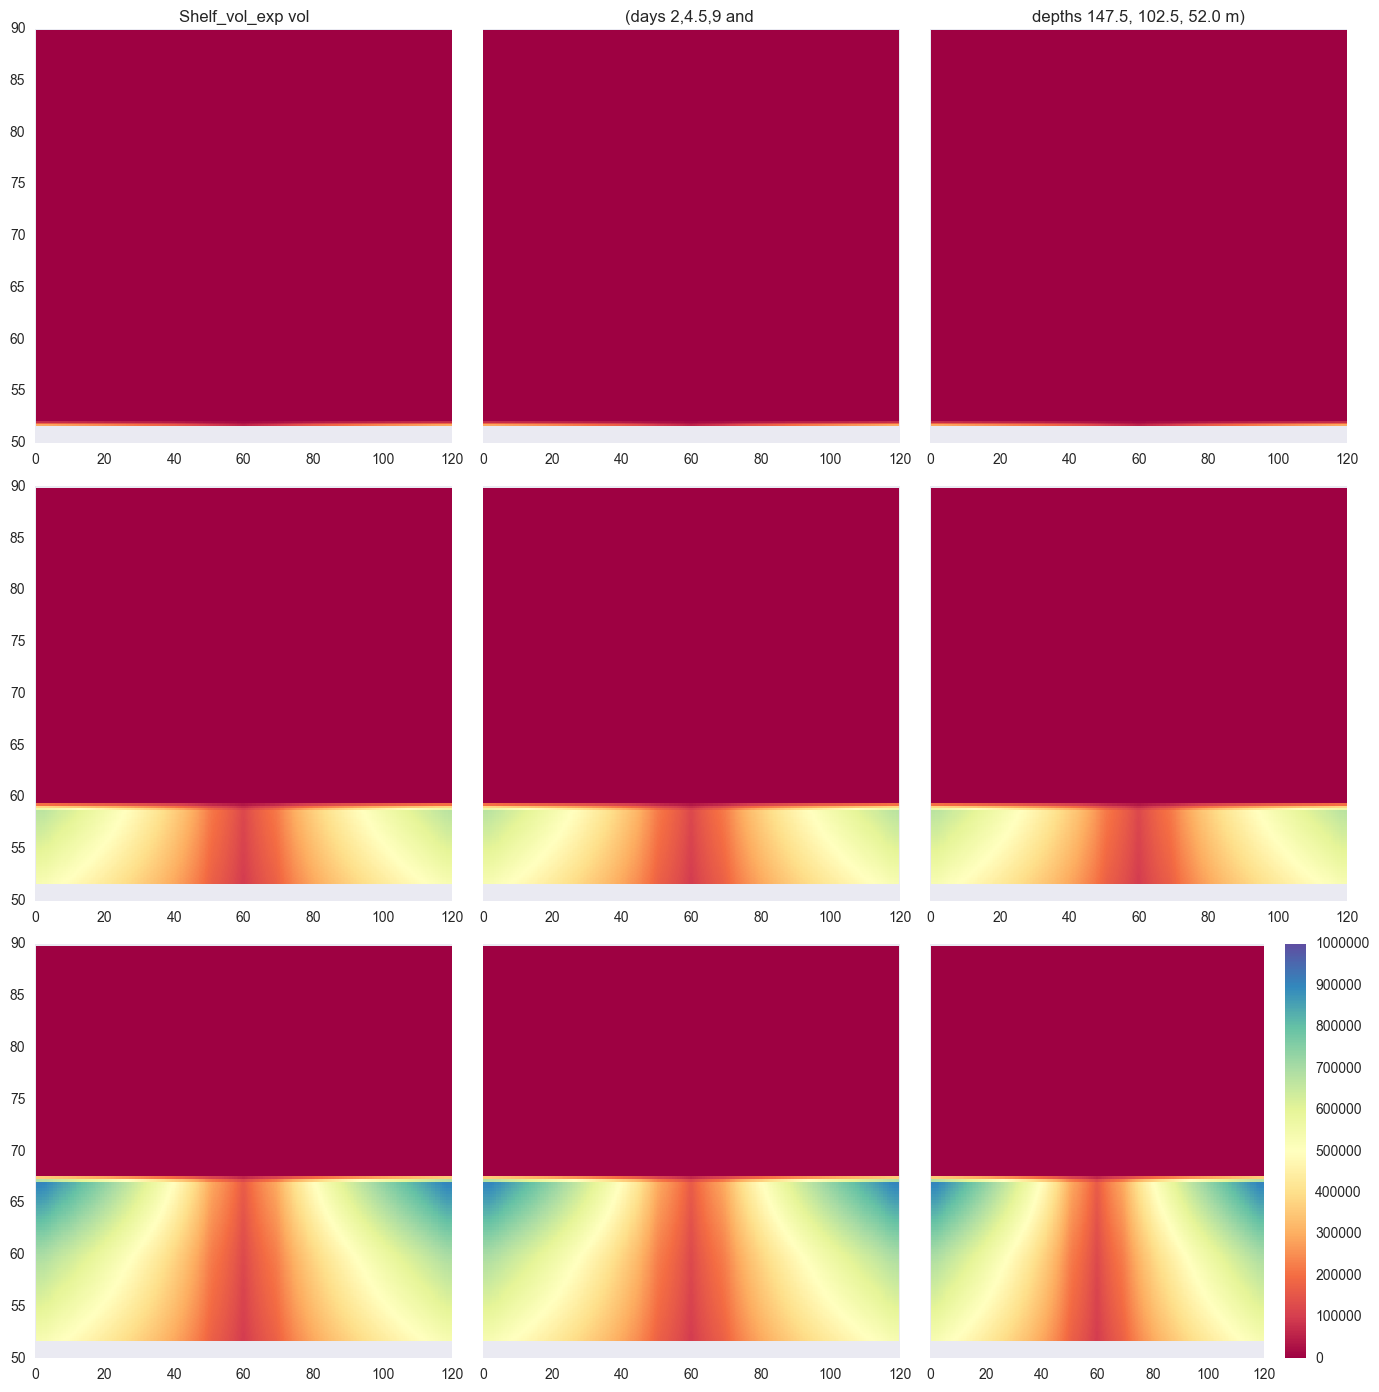

In [20]:
fig, ax = plt.subplots(3,3,figsize=(14,14),sharey=True)

pc0 = ax[0,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[4,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[0,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[9,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[0,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[18,29,:,:],vmax=1E6,vmin=0, cmap='Spectral')
cb = plt.colorbar(pc2)

pc0 = ax[1,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[4,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[1,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[9,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[1,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[18,20,:,:],vmax=1E6,vmin=0, cmap='Spectral')

pc0 = ax[2,0].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[4,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc1 = ax[2,1].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[9,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')
pc2 = ax[2,2].pcolor(xc[1,:]/1000,yc[227:,1]/1000,ShelfVolume_exp[18,10,:,:],vmax=1E6,vmin=0, cmap='Spectral')

ax[0,0].set_title('Shelf_vol_exp vol')
ax[0,1].set_title('(days 2,4.5,9 and ')
ax[0,2].set_title('depths 147.5, 102.5, 52.0 m)')

plt.tight_layout()

### Total tracer on shelf vs tracer mass in HCW

In [21]:
print(np.sum(ShelfVolume_exp[18,:,:,:]*Tr1Mask[18,:30,227:,:])) # units : m^3 1E-6mol/l of nitrate

print(np.ma.sum(HC_vol[18,:,:,:]*TrConc_HCW[18,:,:,:])) # units : m^3 1E-6mol/l of nitrate

985208508967.0
160526595845.0


In [22]:
print(np.sum(ShelfVolume_expNoC[18,:,:,:]*Tr1MaskNoC[18,:30,227:,:])) # units : m^3 1E-6mol/l of nitrate

print(np.sum(HC_volNoC[18,:,:,:]*TrConc_HCWNoC[18,:,:,:])) # units : m^3 1E-6mol/l of nitrate

952966655324.0
5746028464.93


In [23]:
print(np.sum(ShelfVolume_exp[0,:,:,:]*Tr1Mask[0,:30,227:,:])) # units : m^3 1E-6mol/l of nitrate
print(np.sum(ShelfVolume_expNoC[0,:,:,:]*Tr1MaskNoC[0,:30,227:,:])) # units : m^3 1E-6mol/l of nitrate


882067536224.0
882067536224.0


<function matplotlib.pyplot.tight_layout>

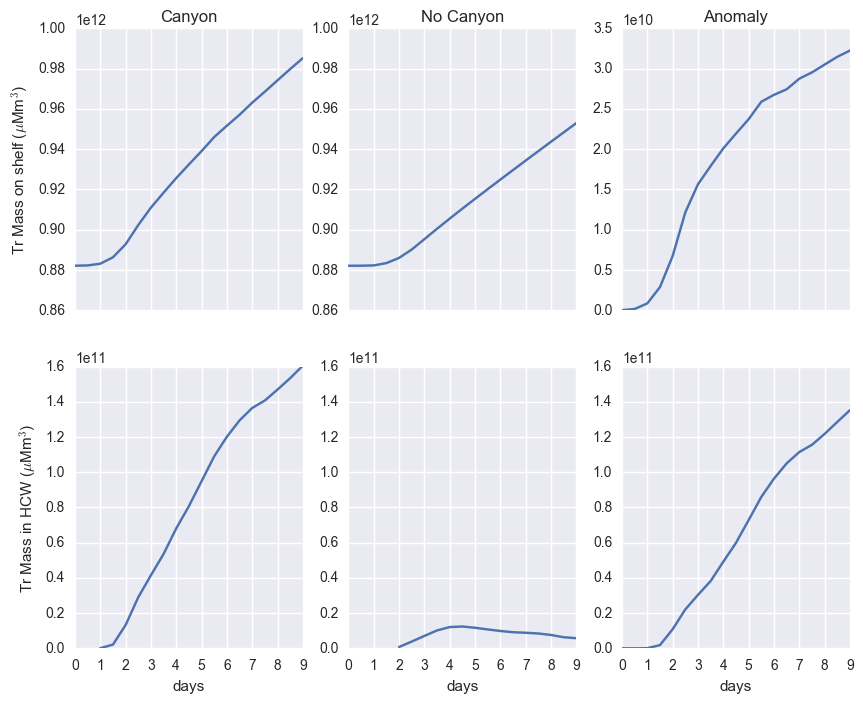

In [24]:
fig, ax = plt.subplots(2,3,figsize=(10,8),sharex=True)
ax[0,0].plot(np.arange(19)/2,np.sum(np.sum(np.sum(ShelfVolume_exp[:,:,:,:]*Tr1Mask[:,:30,227:,:],axis=1),axis=1),axis=1))
ax[0,1].plot(np.arange(19)/2,np.sum(np.sum(np.sum(ShelfVolume_exp[:,:,:,:]*Tr1MaskNoC[:,:30,227:,:],axis=1),axis=1),axis=1))
ax[0,2].plot(np.arange(19)/2,np.sum(np.sum(np.sum((ShelfVolume_exp[:,:,:,:]*Tr1Mask[:,:30,227:,:]
                                                   -ShelfVolume_exp[:,:,:,:]*Tr1MaskNoC[:,:30,227:,:]),axis=1),axis=1),axis=1))

ax[1,0].plot(np.arange(19)/2,np.sum(np.sum(np.sum(HC_vol[:,:,:,:]*TrConc_HCW[:,:,:,:],axis=1),axis=1),axis=1))
ax[1,1].plot(np.arange(19)/2,np.sum(np.sum(np.sum(HC_volNoC[:,:,:,:]*TrConc_HCWNoC[:,:,:,:],axis=1),axis=1),axis=1))
ax[1,2].plot(np.arange(19)/2,np.sum(np.sum(np.sum(((HC_vol[:,:,:,:]*TrConc_HCW[:,:,:,:]).data
                                                   -(HC_volNoC[:,:,:,:]*TrConc_HCWNoC[:,:,:,:]).data),axis=1),axis=1),axis=1))

ax[0,0].set_ylim(8.6E11,10E11)
ax[0,1].set_ylim(8.6E11,10E11)

ax[1,0].set_ylim(0,1.6E11)
ax[1,1].set_ylim(0,1.6E11)
ax[1,2].set_ylim(0,1.6E11)

ax[1,0].set_xlabel('days')
ax[1,1].set_xlabel('days')
ax[1,2].set_xlabel('days')

ax[0,0].set_ylabel('Tr Mass on shelf ($\mu$Mm$^3$)')
ax[1,0].set_ylabel('Tr Mass in HCW ($\mu$Mm$^3$)')

ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')
ax[0,2].set_title('Anomaly')

plt.tight_layout

Everything is fine, I forgot why this made sense, oops. Say parcels with concentration equal or greater than the threshold (Concentration right below shelf break z[30]) are like black balls. The tracer on shelf is made out of balls of many colors, some of the cells on shelf happen to have a black ball. HCW counts how many black balls I have on shelf. For the threshold I picked, HCW in the no canyon case is small but that doesn't mean that other colors of balls are not getting in and out. That is what the total tracer mass tells us. Somehow, the total tracer mass on shelf for the canyon and no canyon cases are similar (difference is about 3% by day 9 ) but it is only in the canyon case that a lot of black balls (deeper water) gets onto the shelf.